In [36]:
%matplotlib inline

import torch
from torch import nn
import numpy as np
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (12, 7)

# Fonction cible

Pour voir comment approximer une fonction par un réseau de neurones, on va rester en dimension 1 pour pouvoir visualiser l'approximation faite par le NN.

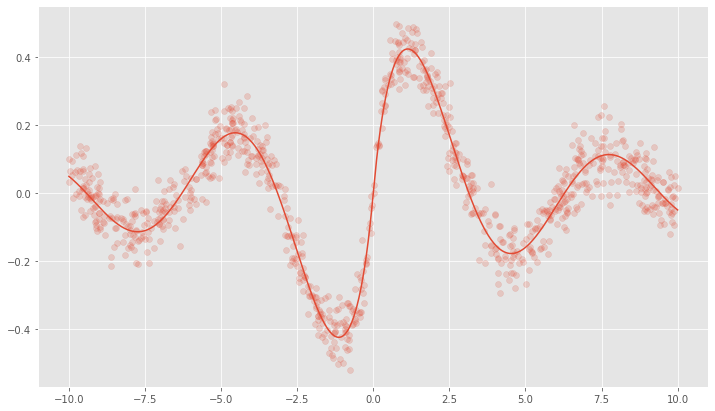

In [8]:
f = lambda x: np.sin(x) / (np.abs(x)+1)

X = np.random.uniform(-10, 10, size=1000)
y = f(X) + np.random.randn(1000) / 20

linspace = np.linspace(X.min(), X.max(), 1000)

plt.scatter(X, y, alpha=0.2)
plt.plot(linspace, f(linspace))

# Création du modèle

In [13]:
class Model(nn.Module):
    def __init__(self, hidden_size=8, hidden_layers=2):
        super().__init__()
        
        self.layers = nn.ModuleList(
            [nn.Linear(1, hidden_size)]
            + [nn.Linear(hidden_size, hidden_size) for _ in range(hidden_layers)]
            + [nn.Linear(hidden_size, 1)]
        )

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = torch.relu(layer(x))
        x = self.layers[-1](x)
        return x

In [52]:
X_pt = torch.tensor(X, dtype=torch.float).reshape(-1, 1).cuda()
y_pt = torch.tensor(y).reshape(-1, 1).cuda()
linspace_pt = torch.tensor(linspace, dtype=torch.float).reshape(-1, 1).cuda()

def train_model(hidden_size, hidden_layers, n_epochs=3000, learning_rate=0.01):
    model = Model(hidden_size=hidden_size, hidden_layers=hidden_layers).cuda()

    n_epochs = n_epochs
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    pb = tqdm(total=n_epochs)
    for epoch in range(n_epochs):
        output = model(X_pt)
        loss = ((output - y_pt)**2).mean()
        loss.backward()
        
        pb.set_postfix_str(f"loss={loss.item():.3f}")
        #if epoch % 1000 == 0:
        #    tqdm.write(f"{epoch:0>4d} -> loss={loss.item():.3f}")

        optimizer.step()
        optimizer.zero_grad()
        pb.update()
    return model

In [53]:
def train_and_visualize_model(hidden_size, hidden_layers, n_epochs=3000, learning_rate=0.01):
    model = train_model(hidden_size, hidden_layers, n_epochs, learning_rate)
    pred = model(linspace_pt).detach().cpu().numpy().squeeze()
    plt.plot(linspace, f(linspace), label="true")
    plt.plot(linspace, pred, ls="--", label="pred")
    plt.legend()

  0%|          | 0/1000 [00:00<?, ?it/s]

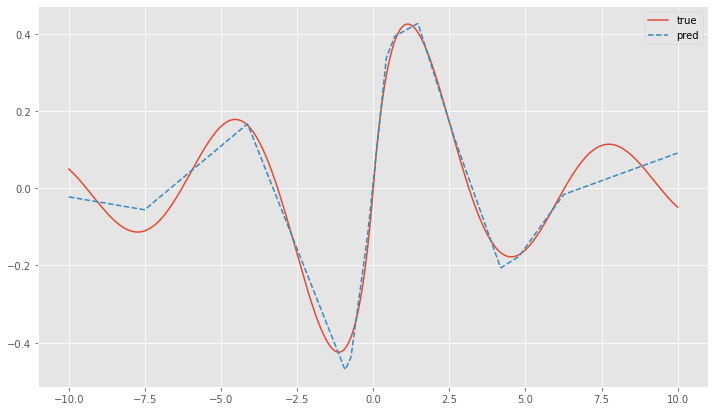

In [55]:
train_and_visualize_model(hidden_size=8, hidden_layers=1, n_epochs=1000, learning_rate=0.001)

  0%|          | 0/1000 [00:00<?, ?it/s]

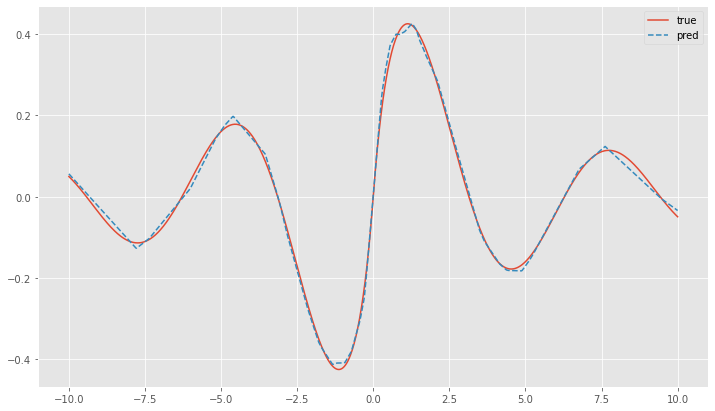

In [56]:
train_and_visualize_model(hidden_size=32, hidden_layers=2, n_epochs=1000, learning_rate=0.001)

  0%|          | 0/1000 [00:00<?, ?it/s]

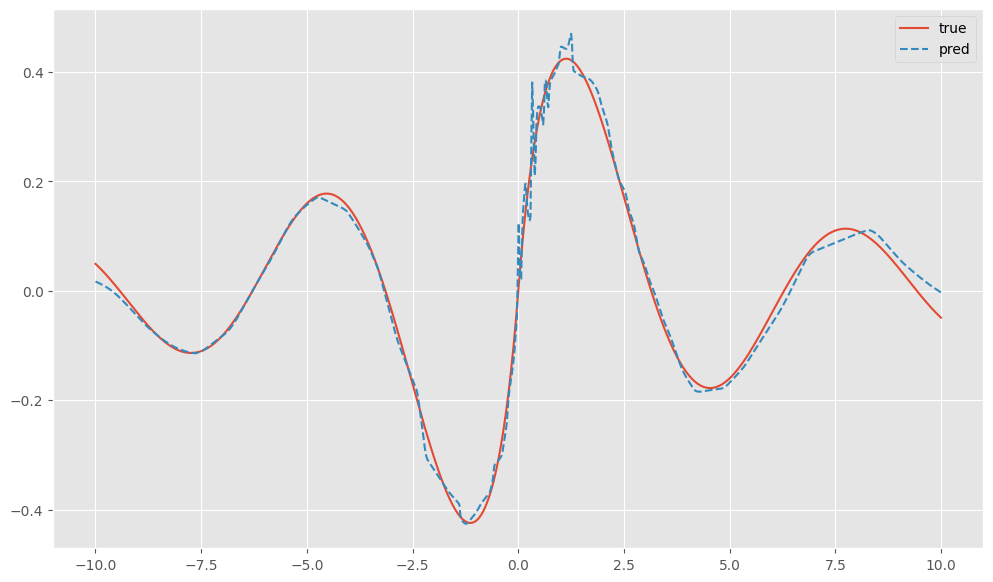

In [9]:
train_and_visualize_model(hidden_size=2048, hidden_layers=8, n_epochs=1000, learning_rate=0.001)

Quand on donne trop de puissance au modèle, il finit par apprendre le bruit et les prédictions deviennent moins bonnes: c'est l'overfitting.